# ***Quantum Face Classification***

            Vivek velivela
            12704286

# **INTRODUCTION**

This Collaboratory Notebook contains Code on how to implement Quantum Neural Network on custom built Dataset. Tensorflow Quatum is used as a Quantum neural Network Architecture. CirQ is also used to encode the data and circuit design.
This Notebook will demonstrate how classical and quantum Neural Networks are different and will also explain the code.

# **Importing google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Importing Necessary Packages**

In [ ]:
!pip install tensorflow==2.3.1
!pip install tensorflow-quantum
import numpy
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import random 
from PIL import Image
import tensorflow_quantum as tfq
import cirq
import sympy
import collections
# visualization tools
from cirq.contrib.svg import SVGCircuit
from skimage import color
from skimage import io

     |████████████████████████████████| 320.4MB 50kB/s 
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 5.9MB 3.4MB/s 
     |████████████████████████████████| 1.6MB 32.2MB/s 
     |████████████████████████████████| 5.6MB 24.5MB/s 
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1


# **Importing and Visualizing Dataset**

I have used a custom built dataset of faces of my friend and myself. We have two classes for this project. This Dataset is built for another project for another subject but I took permission from my friend to use his face images.I had 50 images collected for each class and I have augmented it to 100 using Data Augmentor.So Now we have 100 of each class Which are already divided into testing and training in 80-20 basis and placed into respective folders.

In [ ]:
IMG_WIDTH=224
IMG_HEIGHT=224
train_img_folder=r'/content/gdrive/My Drive/PMP,Discrete and Quantum/Quantum Computing/images/train'
test_img_folder=r'/content/gdrive/My Drive/PMP,Discrete and Quantum/Quantum Computing/images/test'

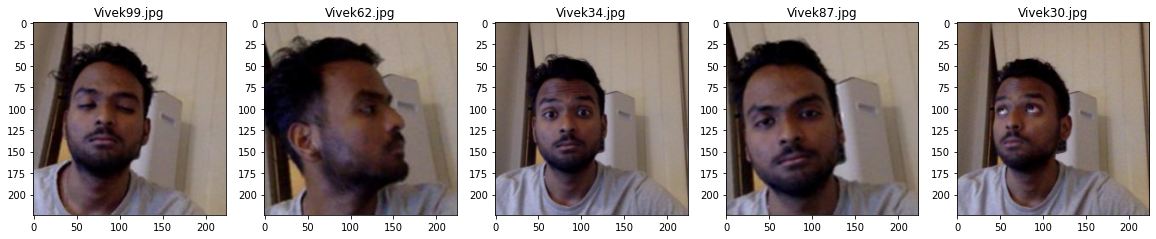

In [ ]:
plt.figure(figsize=(20,20))
test_folder=r'/content/gdrive/My Drive/IPPR/Photos/Vivek'
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

# **Data Pre-processing**
Some Data pre-processing techniques have been performed such as 


*   **Normalization:**This is also one of the standard pre-processing techniques which reduces the pixel intensity values and ranges them between 0 and 1 which will be convinient for processing instead of having a huge range of intensity ranging 0-255.
*   **Data Augmentation:** Data Augmentation is considered to be one of the    standard techniques used if we have less representative data. This process will incrase the smaple size. Now we have 100 images of each class instead of 50. 

*   **Image Re-scaling:** I have re-sized the image from (224,224) to (4,4) as we dont have computing resources that can process each pixel individually. I have re-scaled the image to be a smaller one. all the data will be resized inot a (4,4) matrix.
*   **Remove contradicting Images:** this is not considered as one of the standard pre-processing techniques but in this case as we are converting our original data into a quantum datapoint and data will be changed once the image is resized so we need to make sure that there is no similar pixel data with different labels. Any particular image data which is similar more than 50% will be removed from the dataset.



Here I have encoded all the images into an list of array as we have modern libraries for classical machine learning(ML) that can convert images into list of arrays containing pixel values and processing them while training the ML model but Quantum machine learning is still in initial stages and image classification in QNN must needs more data preperation and organisation in order to convert this data into quantum datapoint. I also have converted the labels to numbers all the labels with "Vivek" is 0 and all the Lables with my friend name "Marcus" is 1.



In [ ]:
def create_dataset_PIL(img_folder):
    
    img_data_array=[]
    class_name=[]
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image= np.array(Image.open(image_path))
            image= np.resize(image,(IMG_HEIGHT,IMG_WIDTH,1))
            image = image.astype('float32')
            image /= 255
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array , class_name




In [ ]:
PIL_img_data1, class_name1 = create_dataset_PIL(train_img_folder)
PIL_img_data2, class_name2 = create_dataset_PIL(test_img_folder)
x_train = PIL_img_data1
x_test =  PIL_img_data2

In [ ]:
y_train = []
for x in class_name1:
  if x =="Vivek":
    x= 0
  else:
    x = 1
  y_train.append(x)
y_train = np.array(y_train)

      

In [ ]:
y_test = []
for x in class_name2:
  if x =="Vivek":
    x= 0
  else:
    x = 1
  y_test.append(x)
y_test = np.array(y_test)


In [ ]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

1


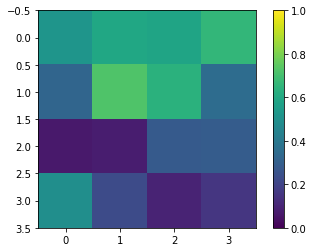

In [ ]:
print(y_train[0])


plt.imshow(x_train_small[4,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [ ]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for x,y in zip(xs, ys):
      labels = mapping[tuple(x.flatten())]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(list(labels)[0])
      else:
          # Throw out images that match more than one label.
          pass
    
    num_3 = sum(1 for value in mapping.values() if True in value)
    num_6 = sum(1 for value in mapping.values() if False in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of vivek's: ", num_3)
    print("Number of Marcus's: ", num_6)
    print("Number of contradictory images: ", num_both)
    print()
    print("Initial number of examples: ", len(xs))
    print("Remaining non-contradictory examples: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

In [ ]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 159
Number of vivek's:  80
Number of Marcus's:  79
Number of contradictory images:  0

Initial number of examples:  160
Remaining non-contradictory examples:  160


In [ ]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [ ]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 53
Number of vivek's:  22
Number of Marcus's:  32
Number of contradictory images:  1

Initial number of examples:  160
Remaining non-contradictory examples:  148


# **Converting classical image into Quantum Datapoint**

All the Images are encoded into quantum Datapoint so that it can be passed into Circuit(QNN Model).

In [ ]:
def convert_to_circuit(image):
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4,4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit




In [ ]:
x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


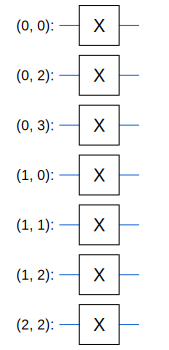

In [ ]:
SVGCircuit(x_train_circ[150])

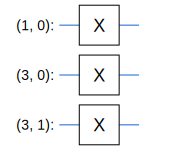

In [ ]:
SVGCircuit(x_test_circ[1])

In [ ]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[3, 0]])

In [ ]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

# **Quantum Neural Network**
Neural Networks in general have three types of layers which are input layer, hidden layers and output layers. Input layer is a kind of layer where all the data will be sent to in the begining. Output layer gives out the result of the data being processed. Hidden layers are a kind of layers which process the data after inputting them the important features will be found out through processing this data through Hidden layers. The architecture of classical Neural Network is as shown below.

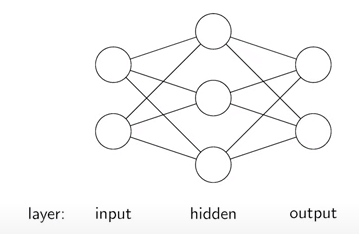

In Case of Classical Neural Networks From Input layer to output layer all the nodes(Perceptron) have to pass the output of previous node make copies of it and have to pass it to next layer's node. In quantum case,  ***No-Cloning Theorem*** prevents to make exact copies of quantum states and send it to other nodes. These Quantum Neural Networks can be imagined as 3D architecture with each node considered as one qubit the action of perceptron is represented as unitary which acts on a particular qubit and all the other qubits connected to it as shown below.


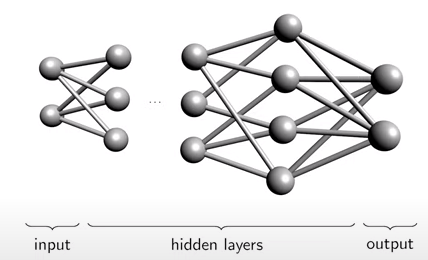

Lets look what happens in each perceptron. At first all the qubits wil be in zero state. Then we send data into input layer then the nodes in input layer will be in input state represented by 
$ \rho^{in} $ and then tensor the qubits of the next layer which are in zero state to this state  as shown in below picture i.e 

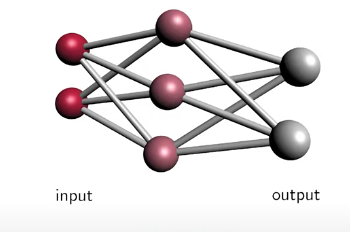


 $ \rho^{in} \otimes |000\rangle_1 \langle 000| $

Then we begin with unitaries of this layer these unitary operations can be considered as connections among input layer and hidden layers as shown below 

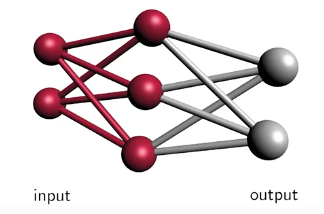

$ U_3^1U_2^1U_1^1(\rho^{in} \otimes |000\rangle_1 \langle 000|)U_1^1U_2^1U_3^1 $ 

The upper index tells us which layer the perceptron(node) is in and lower index tells us about which position does the node in that particualr layer.Next thing is to tensor out the input layer because all the subsequent unitary operations will not affect the input layer. 

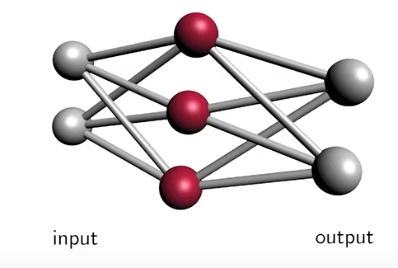

$ tr_{in}(U_3^1U_2^1U_1^1(\rho^{in} \otimes |000\rangle_1 \langle 000|)U_1^1U_2^1U_3^1) $

Now we have state that is in hidden layer the same type of claculation is proceeded with remaining hidden layers until reaches the output layer.Now the output layer is tensored into the current state as shown in below picture and corresponding unitaries are applied as shown in corresponding below picture.

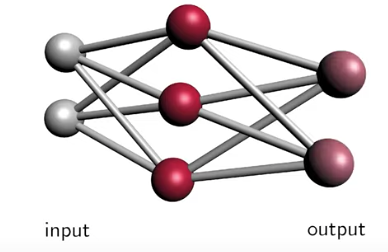
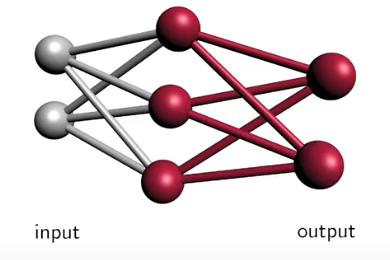

$ U_2^{out}U_1^{out}(tr_{in}(U_3^1U_2^1U_1^1(\rho^{in} \otimes |000\rangle_1 \langle 000|)U_1^1`U_2^1`U_3^1) \otimes |00\rangle_{out} \langle 00|)U_1^{out}`U_2^{out}`$

In the end The hidden layer should be traced out as shown below

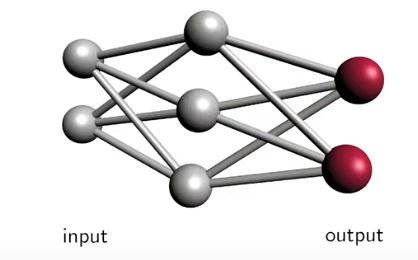

$ tr_1(U_2^{out}U_1^{out}(tr_{in}(U_3^1U_2^1U_1^1(\rho^{in} \otimes |000\rangle_1 \langle 000|)U_1^1`U_2^1`U_3^1) \otimes |00\rangle_{out} \langle 00|)U_1^{out}`U_2^{out}`)$

In this way we always only have unitaries that act on two layers which means the size of unitaries will be hilertspace of number of qubits with two layers.

In [ ]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

In [ ]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.Z(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.YY, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [ ]:
model_circuit, model_readout = create_quantum_model()

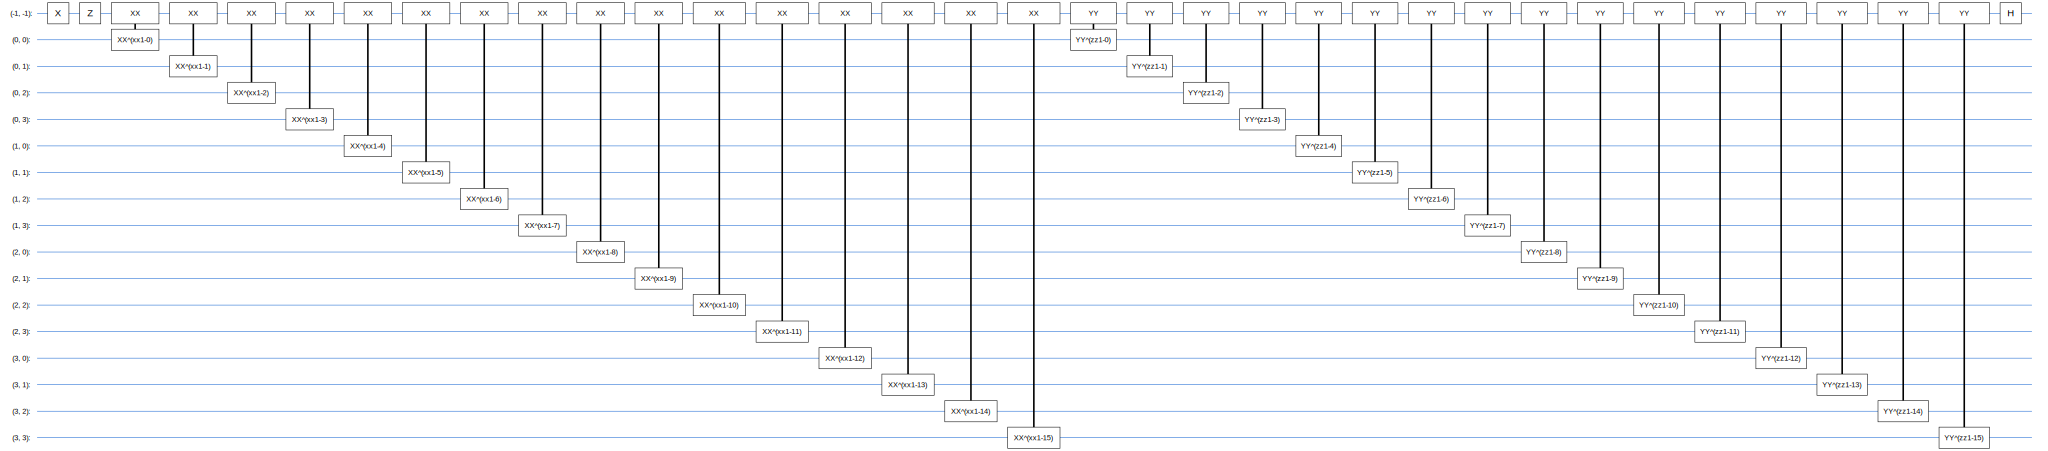

In [ ]:
SVGCircuit(model_circuit)

In [ ]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

# **Defining Accuracy Metric**

In [ ]:
y_train_hinge = []
for x in y_train:
  x = 2.0*x-1
  y_train_hinge.append(x)
y_train_hinge = numpy.array(y_train_hinge) 
y_test_hinge = []
for x in y_test:
  x = 2.0*x-1
  y_test_hinge.append(x)
y_test_hinge = numpy.array(y_test_hinge)

In [ ]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

# **Compiling and Training the Model**

In [ ]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_1 (PQC)                  (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
EPOCHS = 5
BATCH_SIZE = 20

NUM_EXAMPLES = len(x_train_tfcirc)
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train[:NUM_EXAMPLES]

In [ ]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/5
8/8 [==============================] - 8s 1s/step - loss: 1.0000 - hinge_accuracy: 0.5938 - val_loss: 1.0000 - val_hinge_accuracy: 0.5250
Epoch 2/5
8/8 [==============================] - 8s 999ms/step - loss: 1.0000 - hinge_accuracy: 0.6187 - val_loss: 1.0000 - val_hinge_accuracy: 0.5000
Epoch 3/5
8/8 [==============================] - 8s 996ms/step - loss: 1.0000 - hinge_accuracy: 0.6250 - val_loss: 1.0000 - val_hinge_accuracy: 0.5250
Epoch 4/5
8/8 [==============================] - 8s 990ms/step - loss: 1.0000 - hinge_accuracy: 0.5813 - val_loss: 1.0000 - val_hinge_accuracy: 0.5000
Epoch 5/5
2/2 [==============================] - 0s 37ms/step - loss: 1.0000 - hinge_accuracy: 0.6406


# **Results and Challenges**

I faced many challenges while implementing this code on a custom built dataset. The Tensorflow Quantum tutorial in the website have examples with Handwritten MNIST Dataset in which the data is already encoded into list of arrays with all pixel values Whereas in this project it consumed so much time in figuring on how to convert the existing data into MNIST format and run it without any compile error.
Some of the LateX formulas were time consuming.

I have read many papers and watched many videos regarding Quantum Neural Networks I understood the bigger picture of what happens with data when it is passed into QNN. But i believe that i need more knowledge and deeper research to understand how the information is converted, being processed and predicted.


I also have tried to alter the parameters and observe the results subsequently I have change various parameters like Number of epochs, batch size, I also have chnaged the neural network architecture. The results are given below.

Architecture: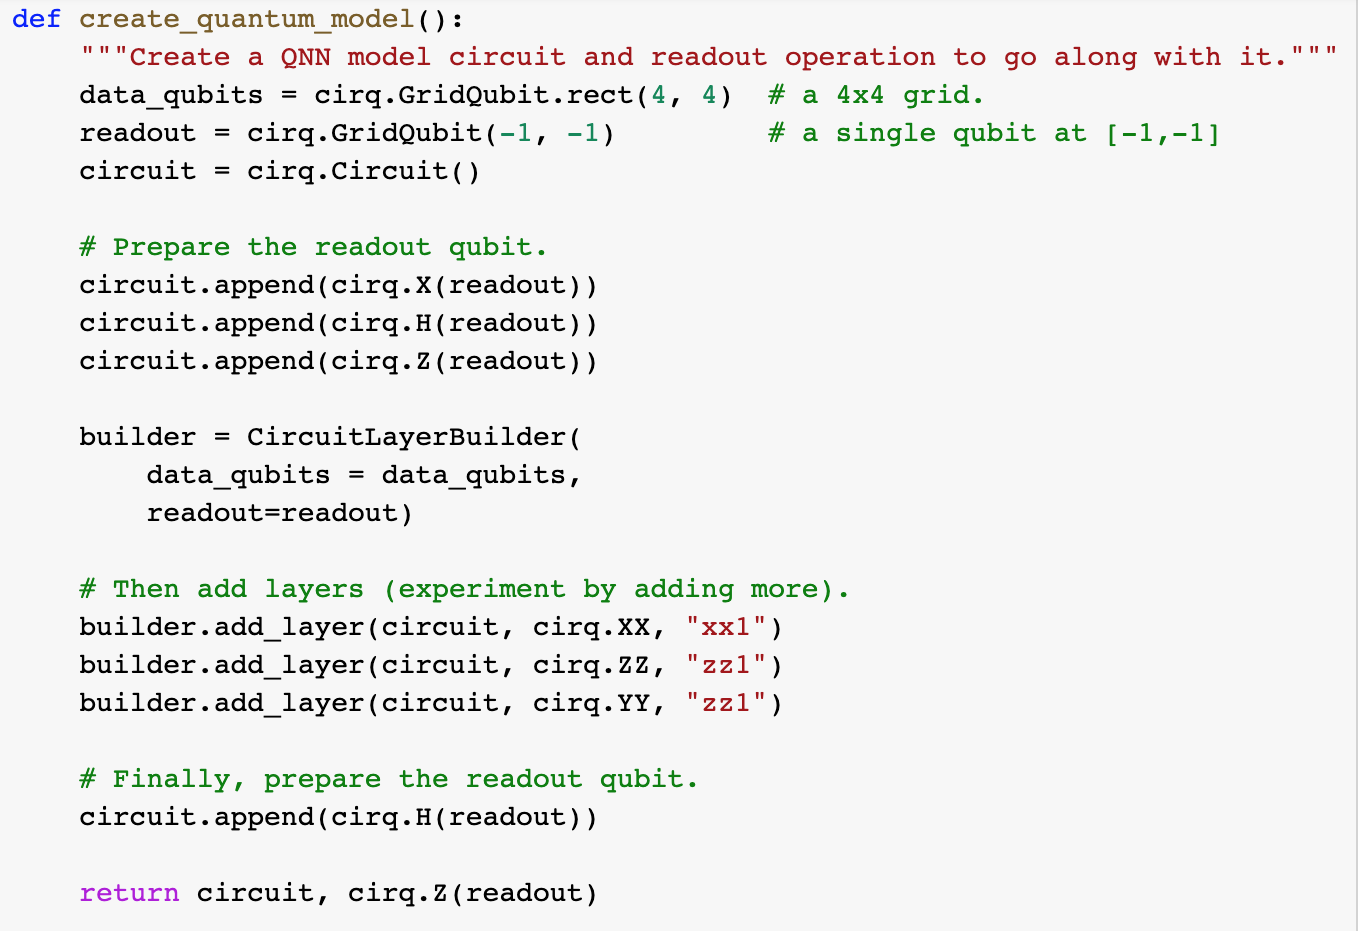

Number of epochs:10
Batch Size:20

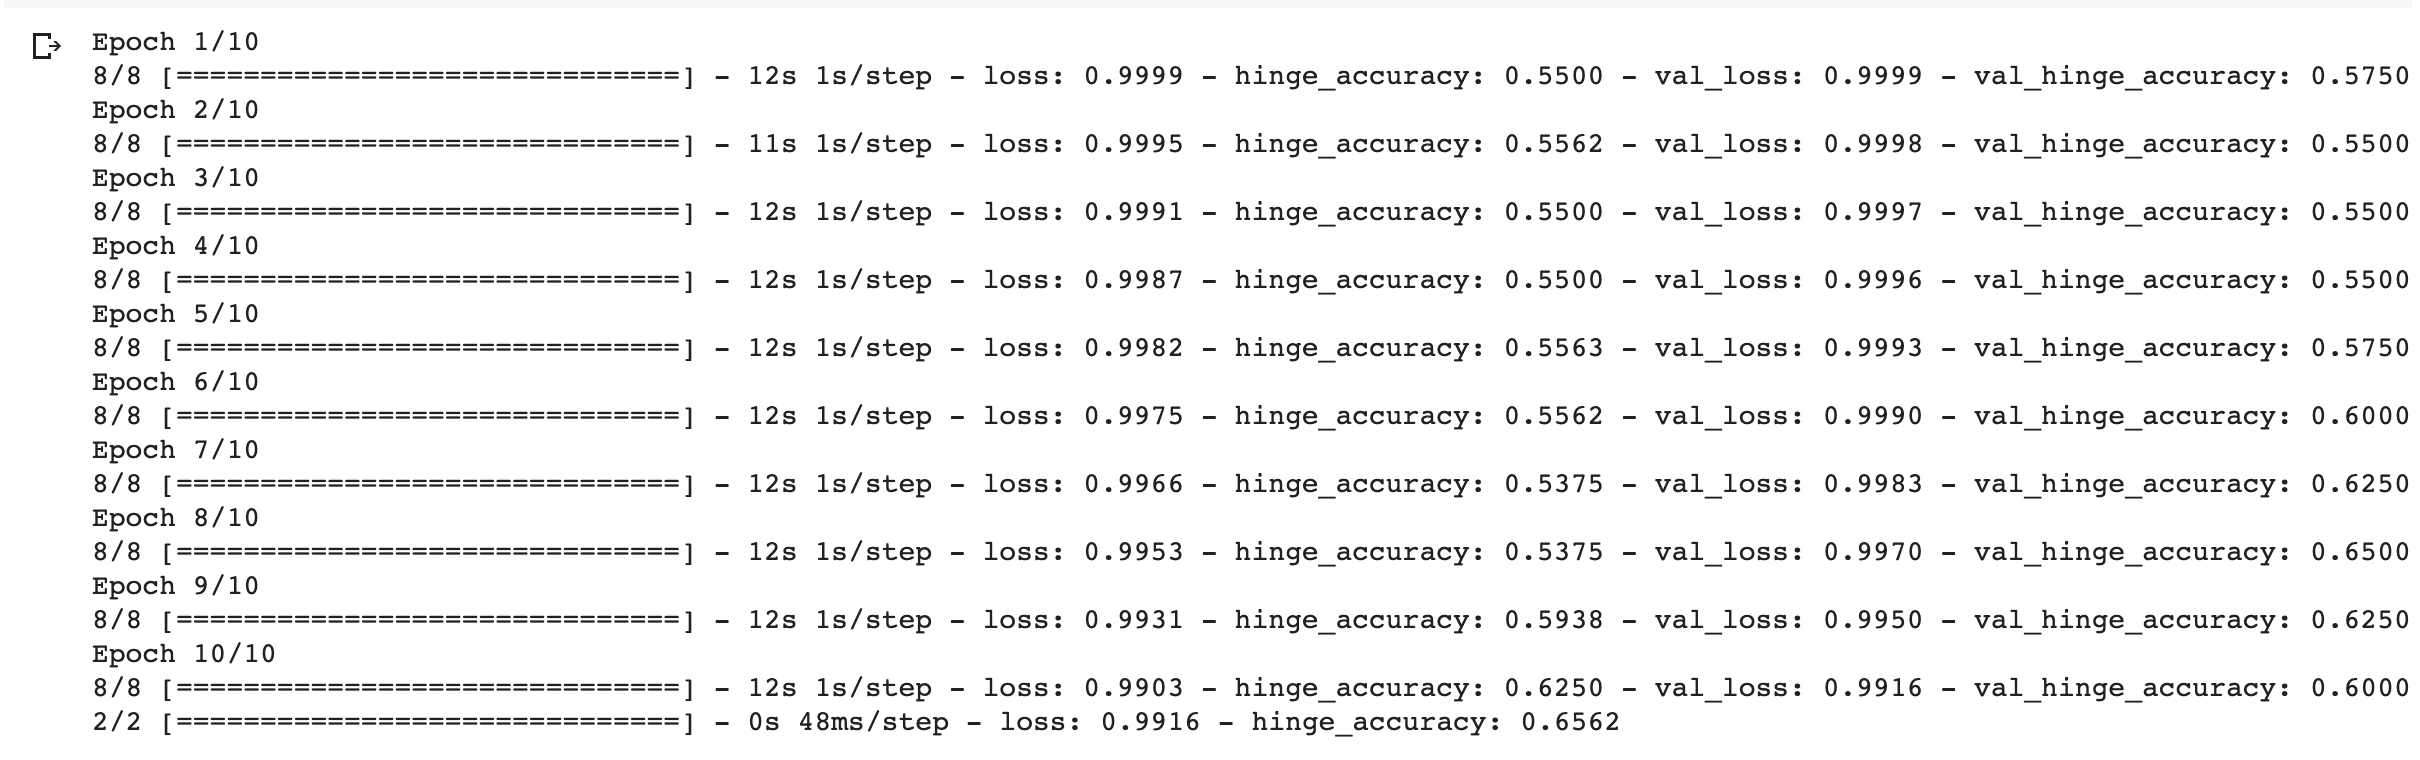

Batch Size :32
Epochs: 10
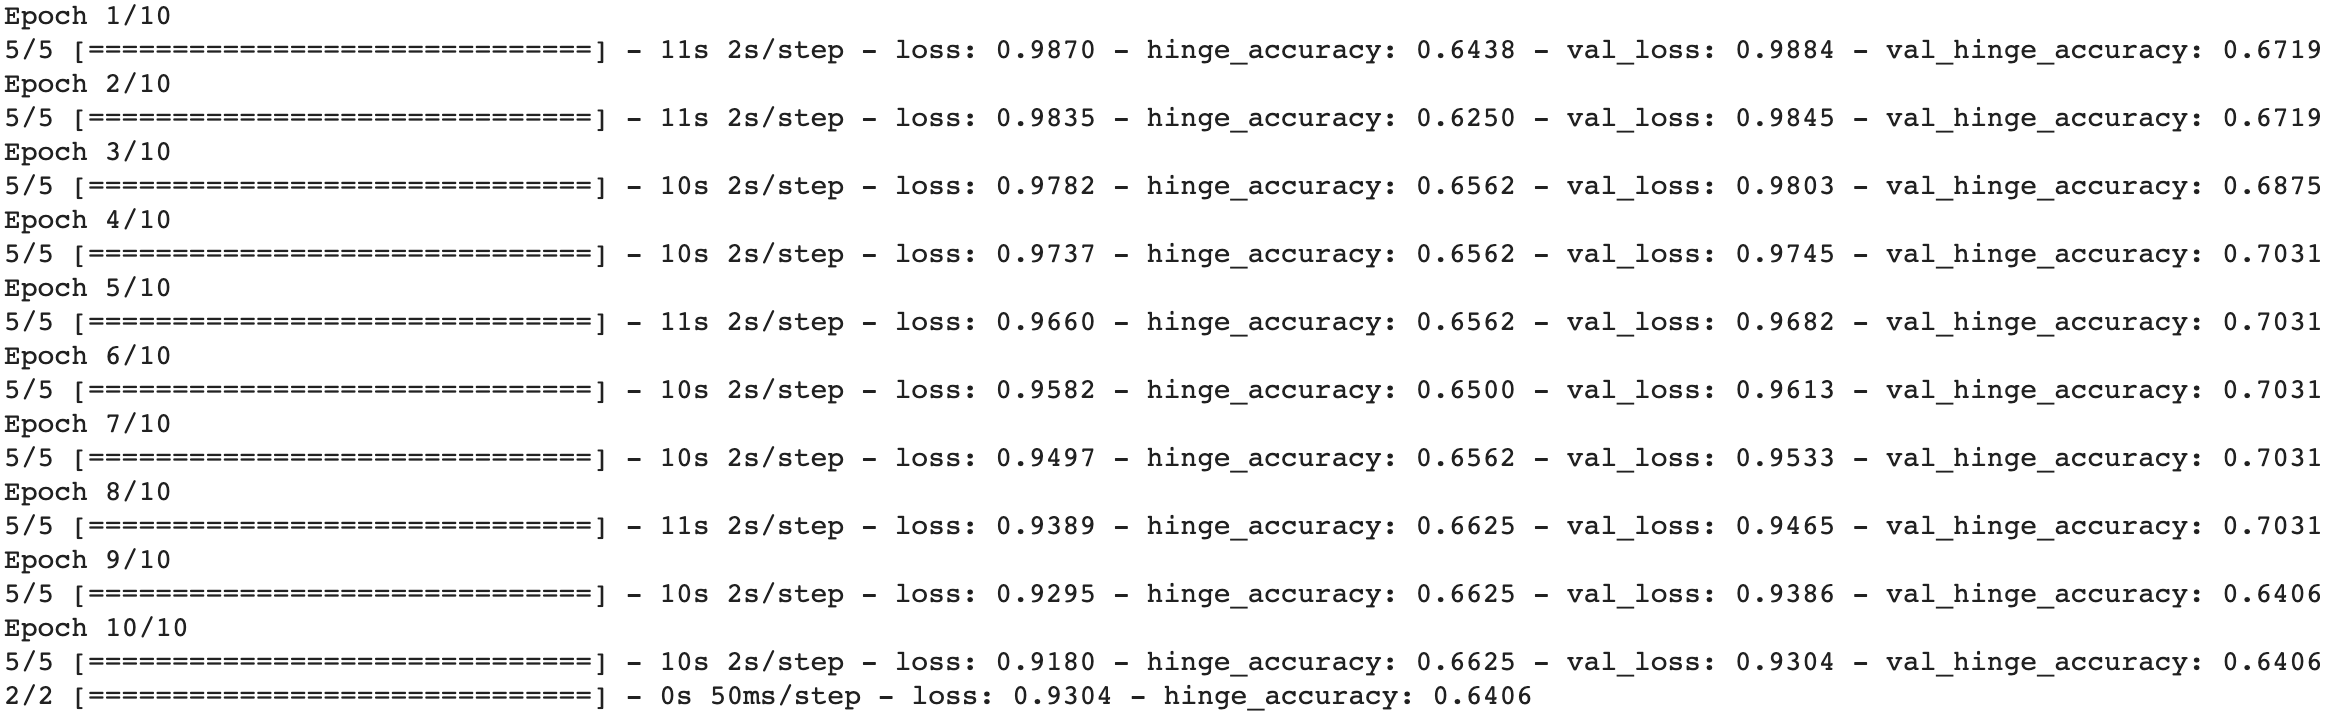


Architecture

Architecture
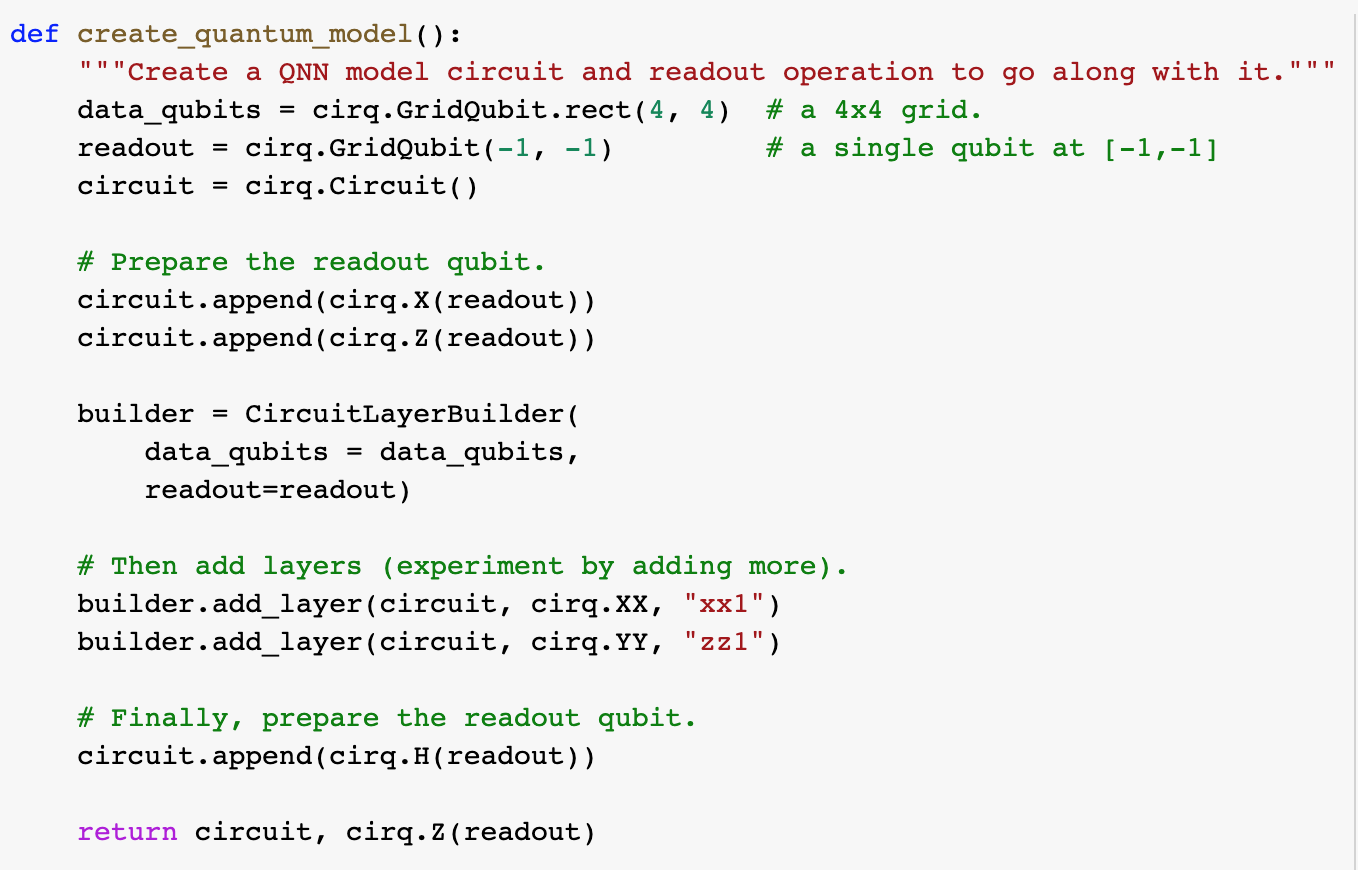

Epochs:10
Batch size:32
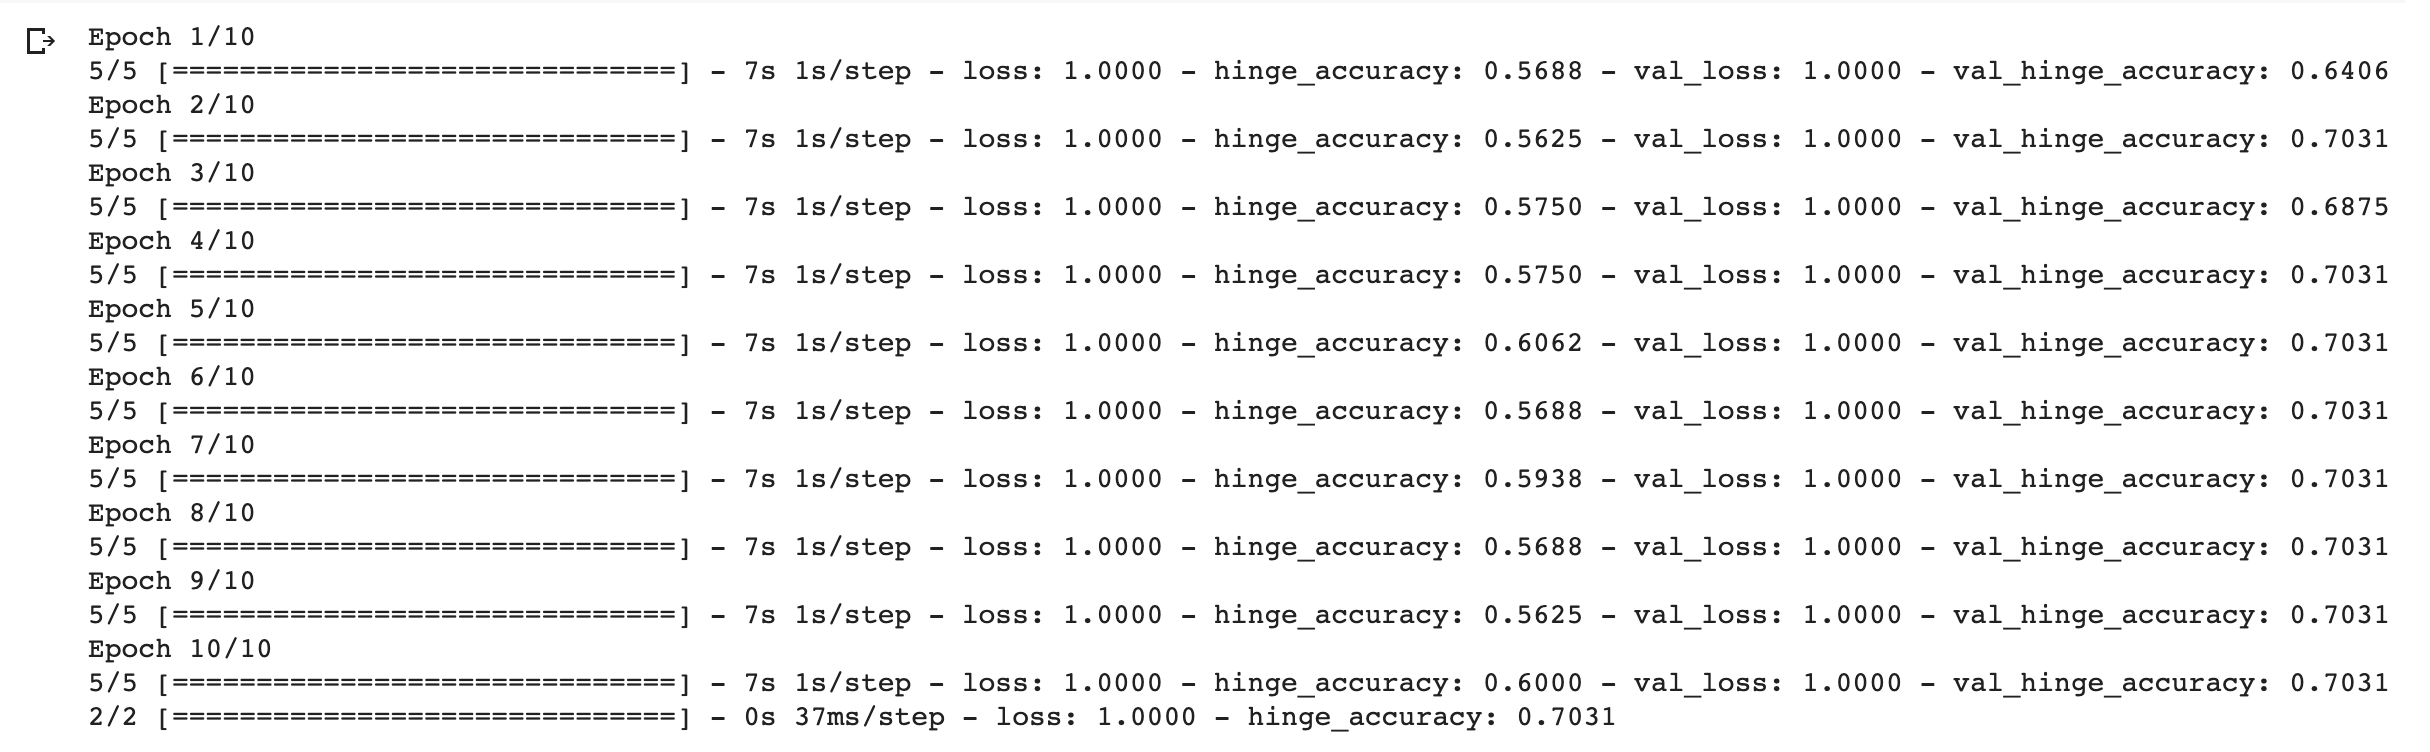



Batch size: 20
Epochs: 5


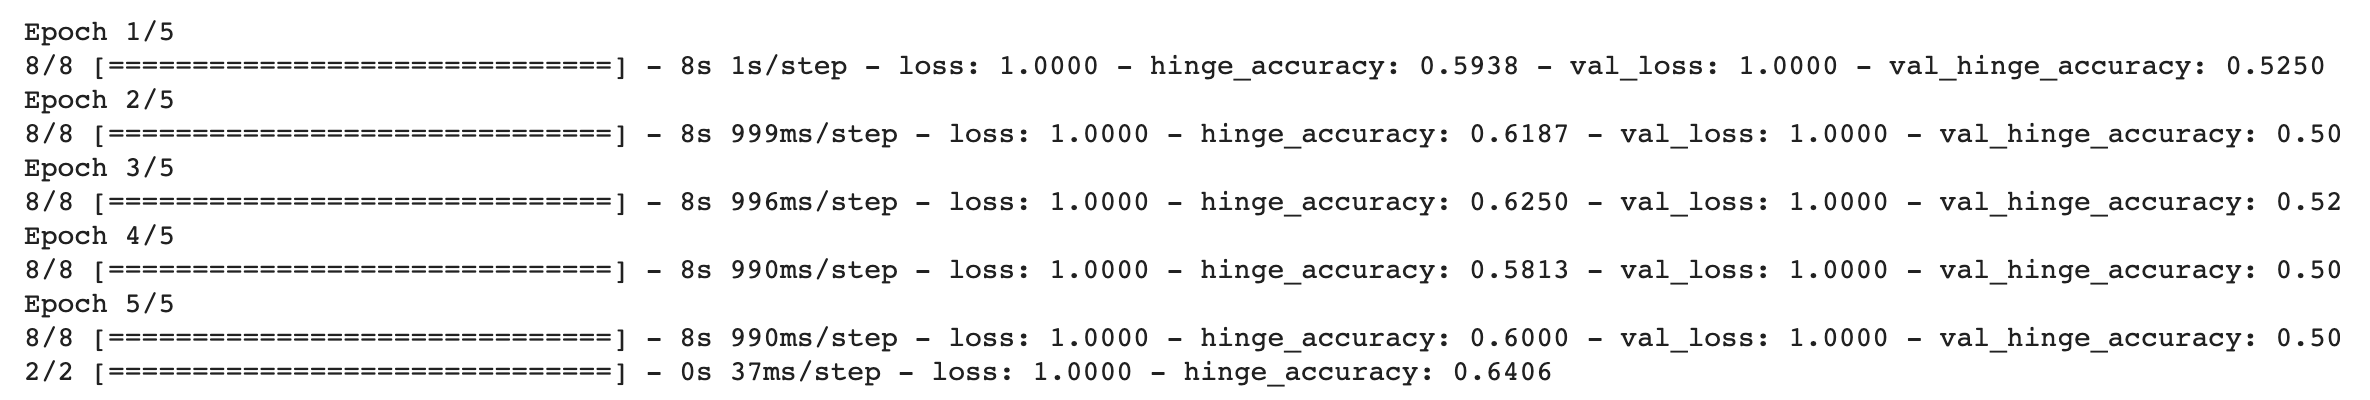

# **BIBLIOGRAPHY**


*   https://arxiv.org/pdf/1802.06002.pdf
*   https://arxiv.org/abs/1902.10445 

*   https://towardsdatascience.com/quantum-neural-networks-for-fintech-dddc6ac68dbf








